In [14]:
# utility
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

dataset = arff.loadarff('./data/ames_housing.arff')
data = pd.DataFrame(dataset[0])

print("Number of rows in the data:", data.shape[0])
print("Number of columns in the data:", data.shape[1])

Number of rows in the data: 2930
Number of columns in the data: 81


## First data engineering
We drop Pool_Qc feature, beacuse is information is already described by the feature Pool_Area

In [15]:
data = data.drop(labels='Pool_QC', axis=1)

## Make data split


In [16]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Sale_Price'])
Y = data['Sale_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.20)

data.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',141.0,31770.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'None',0.0,5.0,2010.0,b'WD ',b'Normal',215000.0,-93.619754,42.054035
1,b'One_Story_1946_and_Newer_All_Styles',b'Residential_High_Density',80.0,11622.0,b'Pave',b'No_Alley_Access',b'Regular',b'Lvl',b'AllPub',b'Inside',...,b'Minimum_Privacy',b'None',0.0,6.0,2010.0,b'WD ',b'Normal',105000.0,-93.619756,42.053014
2,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',81.0,14267.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'Gar2',12500.0,6.0,2010.0,b'WD ',b'Normal',172000.0,-93.619387,42.052659
3,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',93.0,11160.0,b'Pave',b'No_Alley_Access',b'Regular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'None',0.0,4.0,2010.0,b'WD ',b'Normal',244000.0,-93.617320,42.051245
4,b'Two_Story_1946_and_Newer',b'Residential_Low_Density',74.0,13830.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Inside',...,b'Minimum_Privacy',b'None',0.0,3.0,2010.0,b'WD ',b'Normal',189900.0,-93.638933,42.060899


## One hot encoding
We are going to OneHotEncode the discrete variable

In [17]:
from sklearn.preprocessing import OneHotEncoder

#feature trasformate in livello

#tenere solo le feature numeriche


new_X_train = X_train._get_numeric_data()
new_X_test = X_test._get_numeric_data()

#TODO: controllare 'fair', 'Typical'
def refineData(df):
    replace = {
        "Kitchen_Qual": {b'Poor': 0, b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
        "Utilities": {b'AllPub': 1, b'NoSewr': 2, b'NoSeWa': 3},
        "Land_Slope": {b'Gtl': 1, b'Mod': 2, b'Sev': 3},
        "Overall_Qual":{b'Very_Poor': 1, b'Poor': 2, b'Below_Average': 3, b'Average': 4, b'Above_Average': 5, b'Fair': 6, b'Good': 7, b'Very_Good': 8, b'Excellent': 9, b'Very_Excellent': 10},
        "Overall_Cond":{b'Very_Poor': 1, b'Poor': 2, b'Below_Average': 3, b'Average': 4, b'Above_Average': 5, b'Fair': 6, b'Good': 7, b'Very_Good': 8, b'Excellent': 9, b'Very_Excellent': 10},
        "Exter_Qual":{b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
        "Exter_Cond":{b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
    }
    data = df.replace(replace)
    return data

data = refineData(data)

categorical_idx = ['MS_SubClass','MS_Zoning','Street','Alley','Lot_Shape','Land_Contour','Lot_Config','Land_Slope','Neighborhood','Condition_1','Condition_2','Bldg_Type','House_Style','Roof_Style','Roof_Matl','Exterior_1st','Exterior_2nd','Mas_Vnr_Type','Foundation','Bsmt_Qual','Bsmt_Cond','Bsmt_Exposure','BsmtFin_Type_1','BsmtFin_Type_2','Heating','Heating_QC','Central_Air','Electrical','Functional','Fireplace_Qu','Garage_Type','Garage_Finish','Garage_Qual','Garage_Cond','Paved_Drive','Fence','Misc_Feature','Sale_Type','Sale_Condition']

oh = OneHotEncoder(sparse=False, handle_unknown='ignore', min_frequency=0.15, max_categories=5)
oh.fit(X_train[categorical_idx])

X_train_e = oh.transform(X_train[categorical_idx])
X_test_e = oh.transform(X_test[categorical_idx])

for i,col in enumerate(oh.get_feature_names_out()):
    new_X_train[col] = X_train_e[:,i]

for i,col in enumerate(oh.get_feature_names_out()):
    new_X_test[col] = X_test_e[:,i]

#TODO we can try to defragment dataframe

new_X_train.describe()

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Paved_Drive_b'Paved',Paved_Drive_infrequent_sklearn,Fence_b'No_Fence',Fence_infrequent_sklearn,Misc_Feature_b'None',Misc_Feature_infrequent_sklearn,Sale_Type_b'WD ',Sale_Type_infrequent_sklearn,Sale_Condition_b'Normal',Sale_Condition_infrequent_sklearn
count,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,...,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000
mean,58.160836,10002.488908,1970.965017,1984.177048,99.918942,4.197099,49.679608,560.136092,1048.146331,1160.030717,...,0.901451,0.098549,0.799061,0.200939,0.964164,0.035836,0.867747,0.132253,0.820819,0.179181
std,33.285841,6487.019730,30.392293,20.975012,178.752633,2.238542,167.742334,436.698142,446.557224,396.129377,...,0.298120,0.298120,0.400788,0.400788,0.185921,0.185921,0.338837,0.338837,0.383586,0.383586
min,0.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,7413.000000,1953.000000,1965.000000,0.000000,3.000000,0.000000,226.000000,784.000000,875.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,63.000000,9375.000000,1972.000000,1993.000000,0.000000,3.000000,0.000000,462.000000,986.500000,1085.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,78.000000,11500.000000,2001.000000,2004.000000,157.250000,7.000000,0.000000,806.000000,1300.000000,1383.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,313.000000,159000.000000,2010.000000,2010.000000,1600.000000,7.000000,1526.000000,2336.000000,6110.000000,5095.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\david\AppData\Local\Temp\ipykernel_7180\832564798.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(X_train.corr(), annot=True, fmt="0.1")


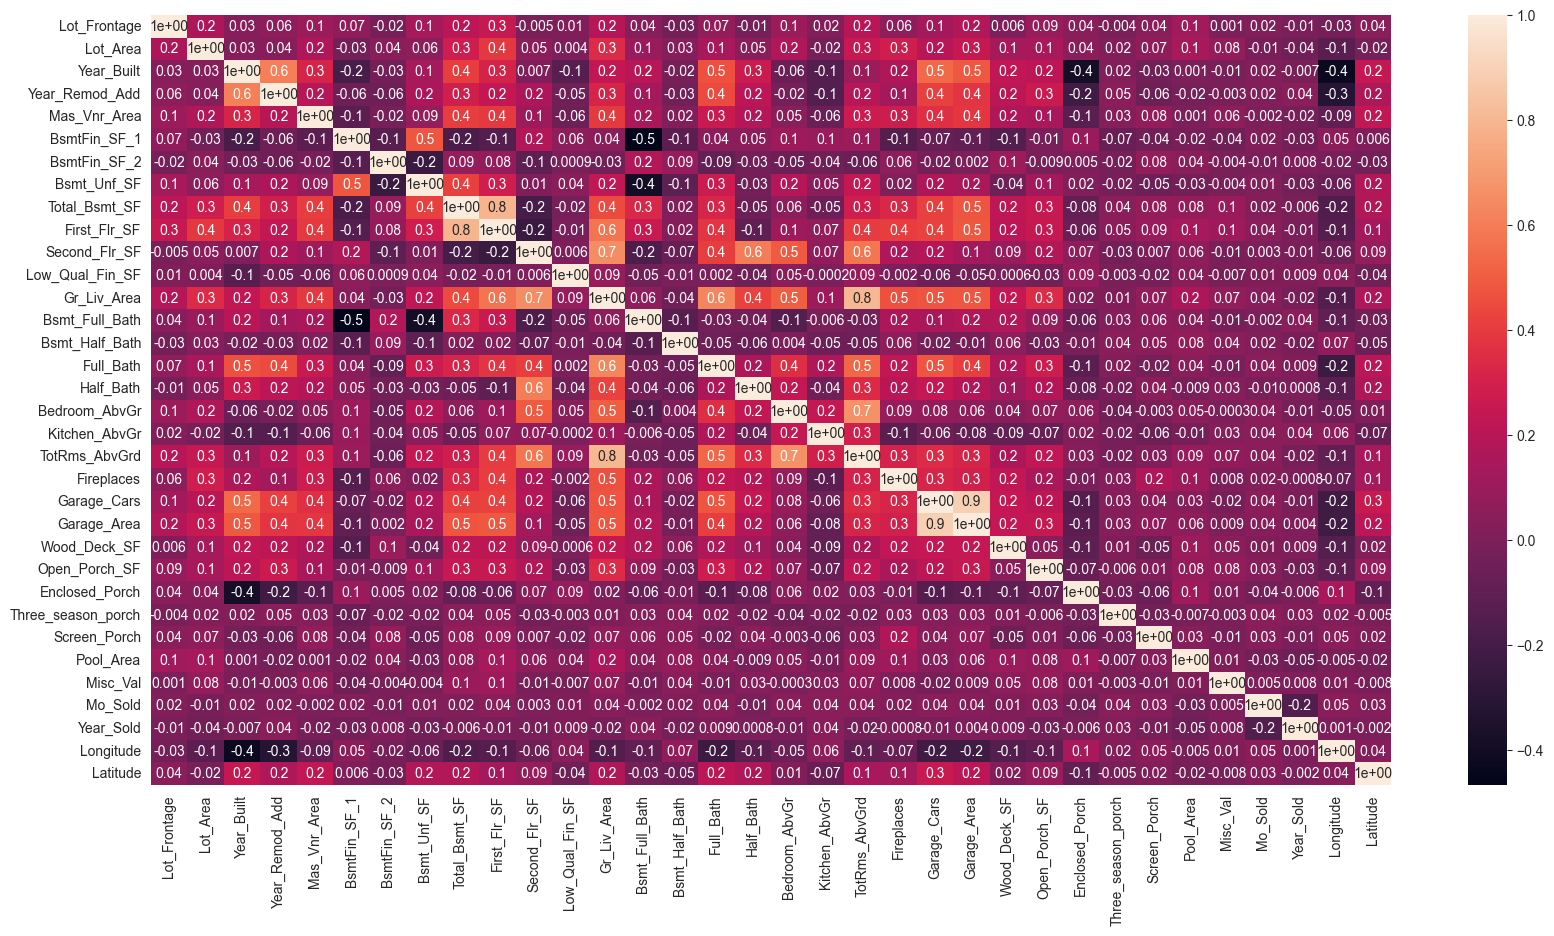

In [18]:
#figure size
plt.figure(figsize=(20, 10))
#heat map for correlation coefficient
sns.heatmap(X_train.corr(), annot=True, fmt="0.1")
plt.show()

# Plot some plot for correlatted features

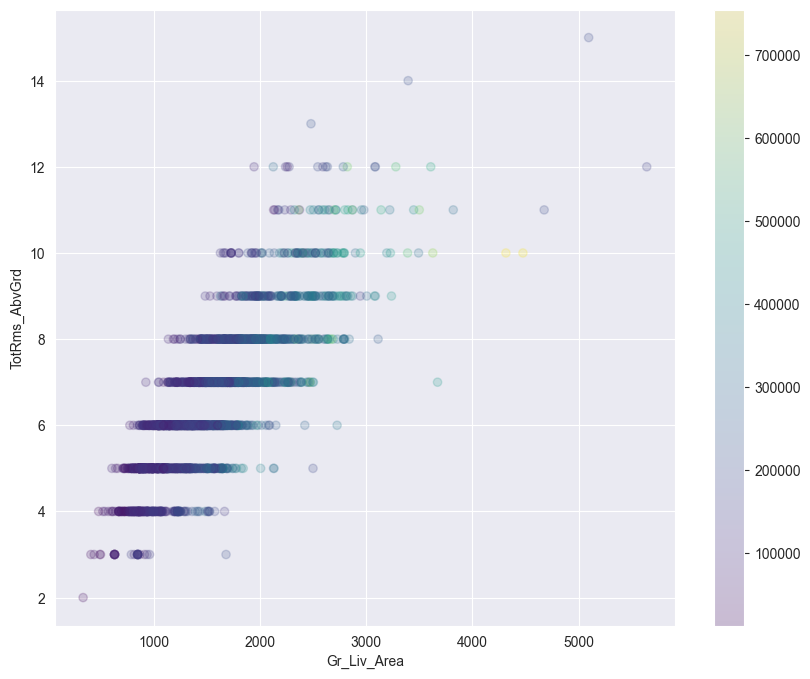

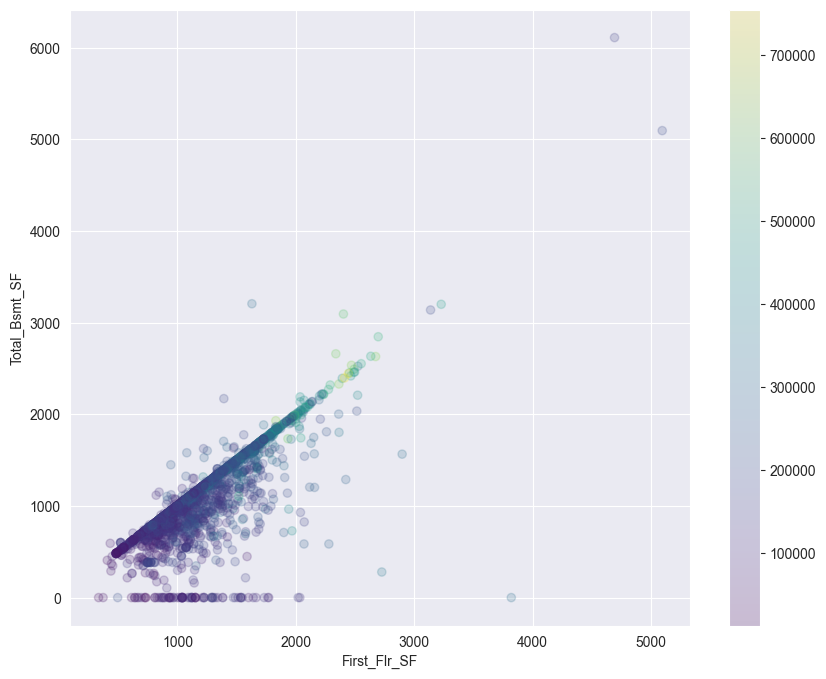

In [19]:
fig, axs = plt.subplots(figsize=(10, 8))

pos = plt.scatter(data.Gr_Liv_Area, data.TotRms_AbvGrd, c = data.Sale_Price, cmap="viridis", alpha=0.2)
axs.set_xlabel('Gr_Liv_Area')
axs.set_ylabel('TotRms_AbvGrd')
fig.colorbar(pos)
plt.show()


fig, axs = plt.subplots(figsize=(10, 8))

pos = plt.scatter(data.First_Flr_SF, data.Total_Bsmt_SF, c = data.Sale_Price, cmap="viridis", alpha=0.2)
axs.set_xlabel('First_Flr_SF')
axs.set_ylabel('Total_Bsmt_SF')
fig.colorbar(pos)
plt.show()


# Save dataframe in a csv file

In [20]:
new_X_train.to_csv('./data/X_train.csv')
new_X_test.to_csv('./data/X_test.csv')